In [1]:
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

In [3]:
def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

In [4]:
def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

In [5]:
def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y_train, y_pred)
    return r2, y_pred

In [6]:
def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

In [7]:
def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

In [148]:
def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

In [149]:
def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(r2_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(r2_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./app_domain.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

In [150]:
# Load Data Train csv
train = pickle.load(open('data/train_bams.p','rb'))
test = pickle.load(open('data/test_bams.p','rb'))
train.shape, test.shape

((107, 1876), (27, 1876))

# SVR_RBF

In [151]:
# Load Pickle rbf
params = pickle.load(open("r_data/params_rbf_25.p", "rb"))

label_25 = pickle.load(open("data/desc25.pkl", "rb"))
x_train = train.loc[:,label_25].to_numpy()
x_test = test.loc[:,label_25].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax rbf
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'rbf', C = params['C'],
           gamma = params['gamma'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [187]:
rbf = r2_score(y_train, train_rbf[1], y_train=None)
rbf

array([0.79326305])

In [189]:
rbf_normalize = normalize(sc_x_train)
rbf_normalize

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[0.33552066, 0.68264917, 0.79138924, ..., 0.        , 0.33038101,
         0.17589146],
        [0.20006587, 0.17552927, 0.13632775, ..., 0.        , 0.        ,
         0.00250626],
        [0.        , 0.11943254, 0.52635941, ..., 0.        , 0.        ,
         0.33708992],
        ...,
        [0.38742589, 0.49042661, 0.69628658, ..., 0.        , 0.        ,
         0.3385691 ],
        [0.33552066, 0.68264917, 0.77243436, ..., 0.        , 0.34089416,
         0.19660715],
        [0.08663106, 0.46428405, 0.76237958, ..., 0.        , 0.49314194,
         0.30161673]]))

In [191]:
rbf_standardize = standardize(sc_x_train)
rbf_standardize

(array([[ 0.7727087 ,  1.43119267,  1.14100834, ..., -0.16984156,
          0.6711049 , -0.60708259],
        [ 0.04552184, -0.66564733, -1.84076913, ..., -0.16984156,
         -0.57842817, -1.41464082],
        [-1.02852854, -0.89759614, -0.06538221, ..., -0.16984156,
         -0.57842817,  0.14371477],
        ...,
        [ 1.05136107,  0.63639059,  0.7081101 , ..., -0.16984156,
         -0.57842817,  0.15060418],
        [ 0.7727087 ,  1.43119267,  1.05472754, ..., -0.16984156,
          0.71086662, -0.51059725],
        [-0.56345108,  0.52829629,  1.00895913, ..., -0.16984156,
          1.28668252, -0.02150502]]),
 array([0.19158641, 0.3365158 , 0.54072311, 0.22513613, 0.31425234,
        0.20426607, 0.91053881, 0.24413191, 0.1588785 , 0.4953271 ,
        0.63104621, 0.49500338, 0.49500338, 0.49500338, 0.36665231,
        0.49899415, 0.29096305, 0.62879148, 0.48323111, 0.23428725,
        0.62336931, 0.02803738, 0.02803738, 0.15293848, 0.30623393]),
 array([0.18627233, 0.2418496 ,

In [152]:
train_rbf = q2_loo(model, sc_x_train, y_train)
train_rbf

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(array([0.79286398]),
 [7.602532957911484,
  5.385953949181275,
  6.604486127425924,
  6.874881965612499,
  5.672341876960119,
  8.076252713983662,
  6.729967476102271,
  8.950496168312013,
  5.636461246039319,
  6.5894133785072855,
  7.290259431538133,
  6.580733632391879,
  8.089578120744537,
  6.421669639607289,
  7.719853641065152,
  5.4298759204041085,
  7.4216833590801174,
  6.005329465746318,
  5.93784591217732,
  8.373336953397057,
  7.663097783646986,
  7.962166940213549,
  7.176416253960683,
  7.555729343123353,
  9.089792390242826,
  6.291222285722596,
  5.7405206697051,
  6.753974101877093,
  8.485663362145027,
  6.208653920425191,
  5.761335888209318,
  5.793443269706824,
  5.873331248982353,
  5.206128902846696,
  6.680874483681457,
  5.929205233857409,
  6.381798671127488,
  6.482185220161714,
  6.693436648821424,
  5.599516635489017,
  5.66795536147277,
  5.84811744171992,
  7.2601321901517615,
  5.8411277925706235,
  6.354563874906382,
  6.166086237141455,
  5.25056646

In [153]:
test_rbf = q2_loo(model, sc_x_test, y_train)
test_rbf

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(array([-0.80322382]),
 [7.7755580950592265,
  6.261586044783477,
  5.8072287088280214,
  6.639648743762058,
  6.154551176387404,
  8.071341538156759,
  8.408287164489531,
  6.737416300850727,
  5.840933135407099,
  6.837715002172338,
  6.300735275759049,
  9.635767546532549,
  7.392614913792929,
  7.991652928068257,
  7.205073362559975,
  8.821772022352183,
  7.195494861637462,
  7.951973659604134,
  6.16037529722575,
  8.063406457836857,
  6.641044526978773,
  7.1336276090759725,
  7.496650148864704,
  6.484874589422218,
  8.023870164107048,
  9.954113233985163,
  6.236419392475371])

In [193]:
rbf_qsar = qsar_param(y_train, train_rbf[1], d_r2m=True)
rbf_qsar

{'r2': array([0.79776909]),
 'k': 0.9765765077336566,
 'k_dash': 0.960079431836522,
 'r2r0': array([0.00069972]),
 'r2r0_dash': array([0.05942432]),
 'r0r0_dash': array([0.04684867]),
 'rm2_bar': array([0.70149517]),
 'd_rm2': array([0.15485063])}

In [204]:
rbf_y = y_random(model, sc_x_train, y_train, n=10)
rbf_y

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

array([0.77171251])

In [205]:
# leverage(XtX, X)

C:\Users\Bams\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


0.7289719626168224


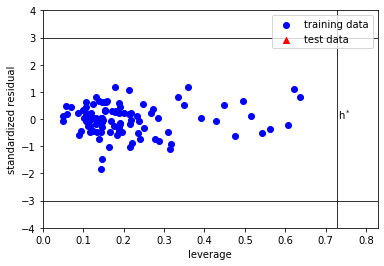

In [208]:
rbf_AD = applicability_domain(x_train, x_test, y_train, train_rbf[1], y_test, test_rbf[1])
rbf_AD

# SVR_Poly

In [177]:
# Load Pickle poly
params = pickle.load(open("p_data/params_poly_25.p", "rb"))

label_25 = pickle.load(open("data/desc25.pkl", "rb"))
x_train = train.loc[:,label_25].to_numpy()
x_test = test.loc[:,label_25].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax poly
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'poly', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [185]:
poly = r2_score(y_train, train_q2_poly[1], y_train=None)
poly

array([0.72862704])

In [210]:
# poly_normalize = normalize(sc_x_train)
# poly_normalize

In [236]:
# poly_standardize = standardize(sc_x_train)
# poly_standardize

In [184]:
train_q2_poly = q2_loo(model, sc_x_train, y_train)
train_q2_poly

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(array([0.72866267]),
 [7.464598777571898,
  5.357944573255603,
  6.551302489897761,
  6.852137017662821,
  5.6635221330996375,
  7.655223852193222,
  6.837645888822161,
  8.722674800010157,
  5.6315556308776396,
  6.827465256313019,
  6.886113181866733,
  6.536960787761403,
  7.577137829040142,
  6.374830132949729,
  7.747657076214823,
  5.357872182974664,
  7.310106842413372,
  6.275089588569551,
  5.902666397851578,
  9.396941816489923,
  7.388232556980693,
  7.9241174515998765,
  7.070480606787859,
  7.624826839307258,
  9.13049112465309,
  6.23952933114535,
  5.651799443962216,
  6.96541864937967,
  8.291672363897916,
  6.246381876424504,
  5.703030940402731,
  5.790779101823075,
  6.0990394410084185,
  5.101882493511588,
  6.74346035734878,
  6.186061079144569,
  6.3301928266702685,
  6.3882650584230305,
  6.383397459265016,
  5.732639692582085,
  5.641601474043844,
  5.990499767300967,
  7.819260938884464,
  6.089402290798574,
  6.332757855613943,
  6.149007261464053,
  5.652088

In [179]:
test_q2_poly = q2_loo(model, sc_x_test, y_train)
test_q2_poly

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(array([-0.96171958]),
 [7.9147893764441015,
  6.842361748640114,
  5.603964138280336,
  6.694844838541269,
  6.573412615381805,
  7.4417006724240515,
  8.298627833684606,
  6.192662536432808,
  6.459017245791912,
  6.249827822686385,
  6.223745775965199,
  8.768746166471153,
  6.890405873616839,
  8.431061954889406,
  6.59516328065903,
  8.428934532194575,
  7.19188209603337,
  8.074825438689691,
  7.558702739504578,
  7.099730787648024,
  6.855813489034513,
  6.869154875693628,
  8.149927537639677,
  7.796261418320504,
  7.401938232497526,
  8.300740084477216,
  6.249286683240376])

In [215]:
poly_qsar = qsar_param(y_test, q2_poly[1], d_r2m=True)
poly_qsar

{'r2': array([0.0995712]),
 'k': 0.9575791127055526,
 'k_dash': 0.7057501060921164,
 'r2r0': array([1.75765841]),
 'r2r0_dash': array([4.08607952]),
 'r0r0_dash': array([0.23184368]),
 'rm2_bar': array([0.04698779]),
 'd_rm2': array([0.02185667])}

In [220]:
poly_y = y_random(model, sc_x_train, y_train, n=10)
poly_y

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

array([0.75892606])

In [221]:
# leverage(XtX, X)

C:\Users\Bams\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


0.7289719626168224


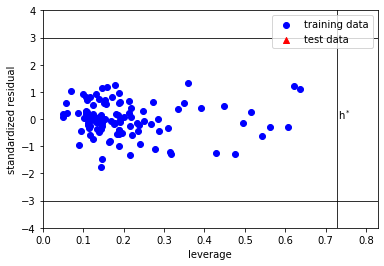

In [222]:
poly_AD = applicability_domain(x_train, x_test, y_train, train_q2_poly[1], y_test, test_q2_poly[1])
poly_AD

# SVR_Linear

In [223]:
# Load Pickle linear
params = pickle.load(open("l_data/params_linear_25.p", "rb"))

label_25 = pickle.load(open("data/desc25.pkl", "rb"))
x_train = train.loc[:,label_25].to_numpy()
x_test = test.loc[:,label_25].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax linear
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'linear', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [230]:
linear = r2_score(y_train, train_q2_linear[1], y_train=None)
linear

array([0.73284074])

In [231]:
# linear_normalize = normalize(sc_x_train)
# linear_normalize

In [239]:
# linear_standardize = standardize(sc_x_train)
# linear_standardize

In [225]:
train_q2_linear = q2_loo(model, sc_x_train, y_train)
train_q2_linear

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(array([0.73328643]),
 [7.338534197251795,
  5.480584995968,
  6.2964586043877055,
  6.840048092802361,
  5.712230741304301,
  7.634121358515955,
  6.647948290618547,
  8.869135606336645,
  5.552402569386549,
  6.938725386984273,
  7.055784269680047,
  6.549501801692108,
  7.526671859634271,
  6.414902116353966,
  7.781302917676982,
  5.342059845982038,
  7.340014416373229,
  6.351113687586945,
  5.837235231619519,
  9.240403943510534,
  7.481707865232137,
  8.012008102214425,
  6.853732905661369,
  7.3172789063129535,
  8.977714622071776,
  6.326286765471732,
  5.567703545199372,
  7.07525431837067,
  8.207212974526916,
  6.114061687994944,
  5.633083213165003,
  5.972628634734373,
  6.074662234350058,
  5.309725494849552,
  6.630578196645276,
  6.295982804097024,
  6.340423252789071,
  6.529469450619059,
  6.283298233853696,
  5.6291356066496565,
  5.4544174196040425,
  6.228605324093179,
  7.400198705851335,
  6.10309119300879,
  6.505780180099997,
  5.984255000700935,
  5.606895414

In [227]:
test_q2_linear = q2_loo(model, sc_x_test, y_train)
test_q2_linear

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(array([-0.7325584]),
 [7.871581611491896,
  7.021482909477623,
  5.796078545609967,
  6.601163480184415,
  6.362266848830816,
  7.35530852368995,
  7.46817455388784,
  6.060285888725391,
  6.427718019961765,
  5.939411560847413,
  5.9775335964670795,
  8.070572029056592,
  6.7321090052661825,
  8.008644025107776,
  6.708167615939525,
  8.669684696208138,
  6.981821966578728,
  7.406107042307626,
  7.594287962008987,
  7.043746936467462,
  6.983527152868956,
  6.759599085088599,
  7.814640203598863,
  7.665427529463208,
  7.401171374157927,
  7.427898586501837,
  6.45565597984713])

In [229]:
linear_qsar = qsar_param(y_test, q2_linear[1], d_r2m=True)
linear_qsar

{'r2': array([0.09829091]),
 'k': 0.9551876745232244,
 'k_dash': 0.6817872637569312,
 'r2r0': array([2.59699687]),
 'r2r0_dash': array([2.79767558]),
 'r0r0_dash': array([0.01972489]),
 'rm2_bar': array([0.04768952]),
 'd_rm2': array([0.00188299])}

In [232]:
linear_y = y_random(model, sc_x_train, y_train, n=10)
linear_y

C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bams\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

array([0.76462104])

In [233]:
# leverage(XtX, X)

C:\Users\Bams\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


0.7289719626168224


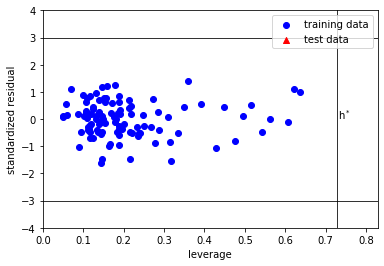

In [234]:
linear_AD = applicability_domain(x_train, x_test, y_train, train_q2_linear[1], y_test, test_q2_linear[1])
linear_AD